In [2]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from scipy import signal
import pywt
from PyEMD import EEMD, EMD
from statsmodels.tsa.arima.model import ARIMA
import time
import os

In [3]:
names = []
classes = []
s_paths = []

for group in os.listdir(f'../N2001/'):
    for muscle in os.listdir(f'../N2001/{group:s}'):
        for subject in os.listdir(f'../N2001/{group:s}/{muscle:s}'):
            # print(f'../N2001/{group:s}/{muscle:s}/{subject:s}/{subject:s}.bin')

            names.append(subject)
            classes.append(group)
            s_paths.append(f'../N2001/{group:s}/{muscle:s}/{subject:s}/{subject:s}.bin')
s_paths[1]

'../N2001/ALS/VastusLateralis/N2001A02VL07/N2001A02VL07.bin'

In [4]:
# for s, n in zip(s_paths, names):
#     with open(s, 'rb') as f:
#         data = f.read()
#         arr = np.array(list(data), dtype=np.uint8)[20:]
#         data = np.array(struct.unpack('h' * int(arr.shape[0] / 2), arr.tobytes()))
        
#         if data.shape[0] != 262134:
#             print(n, s, data.shape)

# arr = np.array(list(data), dtype=np.uint8)[20:]
# arr.shape
# data = np.array(struct.unpack('h' * int(arr.shape[0] / 2), arr.tobytes()))
# data.shape

In [5]:
with open('../N2001/Myopathy/Deltoideus/N2001M04DE58/N2001M04DE58.bin', 'rb') as f:
    data = f.read()
    arr = np.array(list(data), dtype=np.uint8)[20:]
    data = np.array(struct.unpack('h' * int(arr.shape[0] / 2), arr.tobytes()))

    print(data)

data = data / 10

[-273 -254 -305 ... -334 -344 -338]


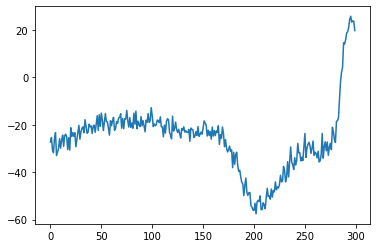

In [6]:
plt.plot(data[:300])

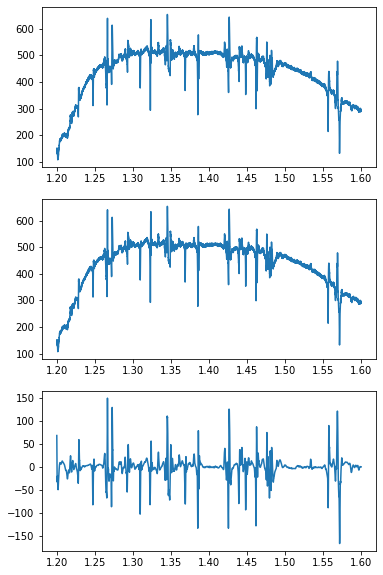

In [7]:
sr = 23437.5
t = np.linspace(0, data.shape[0] / sr, data.shape[0], endpoint=False)
filt = (t > 1.2) * (t < 1.6)

b_notch, a_notch = signal.iirnotch(60.0, 30.0, sr)
data_notched = signal.filtfilt(b_notch, a_notch, data)

b, a = signal.butter(3, 30, 'hp', fs=sr)
data_blo = signal.filtfilt(b, a, data_notched)

wavelet_type='db4'
level = 4
DWTcoeffs = pywt.wavedec(data_blo, wavelet_type, mode='per', level=level, axis=-1)
thresh = 0.63 * np.nanmax(data)
DWTcoeffs[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in DWTcoeffs[1:])

# for i in range(level):
#     DWTcoeffs[-i] = np.zeros_like(DWTcoeffs[-i])
    
data_dwt = pywt.waverec(DWTcoeffs, wavelet_type, mode='per', axis=-1)
if data_dwt.shape[0] > data.shape[0]:
    data_dwt = data_dwt[:data.shape[0]]

# data_blo = signal.sosfilt(sos, data_dwt)

fig, ax = plt.subplots(3, figsize=(6, 10))
ax[0].plot(t[filt], data[filt])
ax[1].plot(t[filt], data_notched[filt])
ax[2].plot(t[filt], data_dwt[filt])

In [8]:
zc_map = np.array([0, 1, 2, 5, 6, 7, 8, 9, 10, 11])
ssc_map = np.array([0, 1, 4, 5])

ar_map = {0: np.array([0, 1, 3]),
        1: np.array([1, 2]),
        2: np.array([2]),
        3: np.array([3]),
        4: np.array([4]),
        6: np.array([0]),
        7: np.array([1]),
        8: np.array([2]),
        12: np.array([0])}

# Freq features mapping
amb_map = np.arange(5)
fmb_map = np.arange(4)
smpds_map = np.array([0, 1, 2, 3, 4, 7])
mfd_map = np.array([3, 4])
mif_map = np.array([0, 1, 2, 3, 5])
ppsd_map = np.array([0, 3, 7])

np.concatenate([zc_map, ssc_map, np.concatenate(list(ar_map.values())), amb_map, fmb_map, smpds_map, mfd_map, mif_map, ppsd_map]).shape

(51,)

In [9]:
def norm(arr):
    return(arr - np.mean(arr)) / np.std(arr)

def denorm(arr, mean, std):
    return(arr * std + mean)
    
start = time.time()
emd = EMD(FIXE=7)
IMFs = emd.emd(data_dwt, t, max_imf=13)
end = time.time()

m, s = [int(_t) for _t in divmod(end - start, 60)]
h, m = [int(_t) for _t in divmod(m, 60)]

print(f'time elapsed: {int(h):d}:{m:02d}:{s:02d}')

nIMFs = IMFs.shape[0] - 1
nIMFs

time elapsed: 0:00:02


13

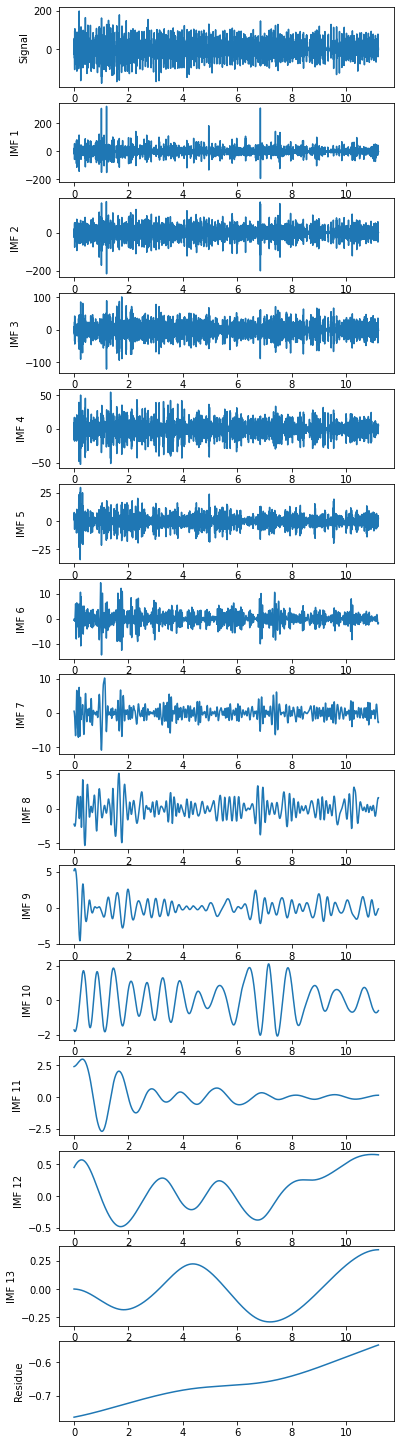

In [10]:
fig, ax = plt.subplots((nIMFs + 2), figsize=(6, nIMFs * 2))

ax[0].plot(t, data_dwt)
ax[0].set_ylabel('Signal')
for i, imf in enumerate(IMFs):
    ax[i + 1].plot(t, imf)
    
    if (i + 1) == 14: ax[i + 1].set_ylabel('Residue')
    else: ax[i + 1].set_ylabel(f'IMF {i+1:d}')

In [11]:
# 10 epochs
q = t.shape[0] % 10

# mean filtered signal
mdata_dwt = np.mean(np.split(data_dwt[:-q], 10), axis=0)

IMFs = IMFs * 1e-6

# mean IMFs
mIMFs = np.mean(np.split(IMFs[:-1, :-q], 10, axis=1), axis=0)
split_IMFs = np.array(np.split(IMFs[:-1, :-q], 10, axis=1))
mt = np.split(t[:-q], 10)[0]

In [12]:
np.array(np.split(IMFs[0, :-q], 10))
#iav = np.sum(np.abs(mIMFs), axis=1)

array([[ 6.88583216e-07,  3.33843756e-07, -1.63426037e-07, ...,
        -1.25423456e-08,  1.12562121e-07,  1.51973549e-07],
       [ 1.68925257e-07,  1.32122137e-07,  1.07229962e-07, ...,
         8.04218948e-08,  7.16116243e-08,  6.47512104e-08],
       [ 5.82469321e-08,  4.91802715e-08,  3.81156494e-08, ...,
         4.61795026e-07,  4.99594316e-07,  5.49065054e-07],
       ...,
       [ 5.92563491e-08,  3.07118149e-08,  8.33375705e-10, ...,
        -9.69993450e-07, -9.65339503e-07, -9.56538982e-07],
       [-9.43364076e-07, -9.30995071e-07, -9.18337841e-07, ...,
        -4.85560153e-07, -4.23481772e-07, -2.15864645e-07],
       [ 6.42763784e-08,  4.50420317e-07,  8.16667973e-07, ...,
         2.17513820e-06,  1.97677834e-06,  1.63153513e-06]])

In [13]:
# np.sum(np.abs(np.diff(split_IMFs[:, 0], axis=1)), axis=1)
np.mean(np.sum(np.abs(split_IMFs[:, 0]), axis=1))

0.1439999701376587

In [14]:
np.mean(np.sum(np.abs(split_IMFs), axis=2), axis=0)

array([0.14399997, 0.27027466, 0.25465107, 0.17504222, 0.10463857,
       0.05280613, 0.03755267, 0.02666065, 0.02122463, 0.02073404,
       0.01421865, 0.00749698, 0.00411915])

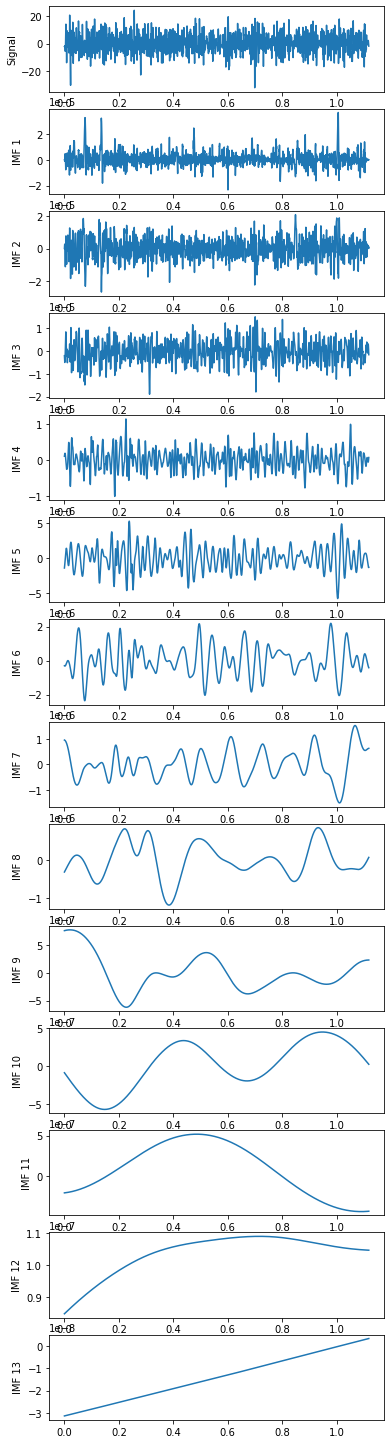

In [15]:
fig, ax = plt.subplots((nIMFs + 1), figsize=(6, nIMFs * 2))

ax[0].plot(mt, mdata_dwt)
ax[0].set_ylabel('Signal')
for i, imf in enumerate(mIMFs):
    ax[i + 1].plot(mt, imf)
    ax[i + 1].set_ylabel(f'IMF {i+1:d}')

In [63]:
# Acá features temporales
# https://lupinepublishers.com/biomedical-sciences-journal/fulltext/a-comprehensive-study-on-eMG-feature-extraction-and-classifiers.ID.000104.php

start = time.time()

zc_map = np.array([0, 1, 2, 5, 6, 7, 8, 9, 10, 11])
ssc_map = np.array([0, 1, 4, 5])

ar_map = {0: np.array([0, 1, 3]),
          1: np.array([1, 2]),
          2: np.array([2]),
          3: np.array([3]),
          4: np.array([4]),
          6: np.array([0]),
          7: np.array([1]),
          8: np.array([2]),
          12: np.array([0])}

# for i in range(nIMFs):
#     imf = split_IMFs[:, i]
    
wl = np.sum(np.abs(np.diff(split_IMFs)), axis=2)
zc = np.sum(np.abs(np.diff(np.sign(split_IMFs))) == 2, axis=2)[:, zc_map]
ssc = np.sum(np.abs(np.diff(np.sign(np.diff(split_IMFs)))) == 2, axis=2)[:, ssc_map]
rms = np.sqrt(np.mean(split_IMFs ** 2, axis=2))

mav = np.mean(np.abs(split_IMFs), axis=2)
iav = np.sum(np.abs(split_IMFs), axis=2)

ar = []

for i in range(nIMFs):
    print(f'Running imf_{i+1:d}:')
    if i not in ar_map:
        print('\tskipping')
        continue
    i_ar = []
    for imf in split_IMFs[:, i]:
        try:
          _ar = ARIMA(imf, order=[6, 0, 0]).fit(method='yule_walker').polynomial_ar[1:][ar_map[i]]
        except Exception as e:
          print(e)
          _ar = np.zeros(6)[ar_map[i]]
        i_ar.append(_ar)        
    ar.append(np.array(i_ar))
    
ar = np.concatenate(ar, axis=1)
    
# ar = np.array([ARIMA(imf, order=[5, 0, 0]).fit().polynomial_ar[1:] for imf in IMFs])


end = time.time()

m, s = [int(_t) for _t in divmod(end - start, 60)]
h, m = [int(_t) for _t in divmod(m, 60)]

print(f'time elapsed: {int(h):d}:{m:02d}:{s:02d}')

t_feat = np.concatenate([wl, zc, ssc, rms, mav, iav], axis=1)

Running imf_1:
Running imf_2:
Running imf_3:
Running imf_4:
Running imf_5:
Running imf_6:
	skipping
Running imf_7:
Running imf_8:
Running imf_9:
Running imf_10:
	skipping
Running imf_11:
	skipping
Running imf_12:
	skipping
Running imf_13:
time elapsed: 0:02:54


In [66]:
t_feat.shape

(10, 78)

In [80]:
start = time.time()

analytic_sig = np.zeros_like(mIMFs, dtype=np.complex64)

mif = np.zeros([10, nIMFs])
mfd = np.zeros([10, nIMFs])
smpds = np.zeros([10, nIMFs])
amb = np.zeros([10, nIMFs])
fmb = np.zeros([10, nIMFs])
ppsd = np.zeros([10, nIMFs])

amb_map = np.arange(5)
fmb_map = np.arange(4)
smpds_map = np.array([0, 1, 2, 3, 4, 7])
mfd_map = np.array([3, 4])
mif_map = np.array([0, 1, 2, 3, 5])
ppsd_map = np.array([0, 3, 7])

for i in range(nIMFs):
  # no queda claro en el paper. Revisar cálculo de amplitud, fase y frecuencia
  # ver https://ccrma.stanford.edu/~jos/st/Analytic_Signals_Hilbert_Transform.html

  # IMF split params
  t_params = np.zeros([10, 6])
  for j, imf in enumerate(split_IMFs[:, i]):
    analytic_sig = signal.hilbert(imf)
    amps = np.abs(analytic_sig)
    phases = np.angle(analytic_sig)

    freqs = np.zeros_like(phases)
    freqs[1:] = np.diff(phases) * sr

    psd = freqs ** 2 / (2 * np.pi)

    t_params[j, 0] = np.sum(freqs * amps ** 2) / np.sum(amps ** 2) # mif 
    t_params[j, 1] = np.sum(np.diff(freqs) * sr) / (freqs.shape[0]) # mfd 
    t_params[j, 2] = np.sum(np.arange(1, psd.shape[0] + 1) * psd) # smpds 
    t_params[j, 3] = np.sum(np.diff(amps ** 2) * sr) / np.sum(psd[:-1]) # amb, así sale en el paper
    t_params[j, 4] = np.sum((freqs - t_params[j, 0]) * amps ** 2) / np.sum(psd) # fmb 
    t_params[j, 5] = np.max(psd) # ppsd

  t_means = np.mean(t_params, axis=0)
  mif[:, i] = t_params[:, 0]
  mfd[:, i] = t_params[:, 1]
  smpds[:, i] = t_params[:, 2]
  amb[:, i] = t_params[:, 3]
  fmb[:, i] = t_params[:, 4]
  ppsd[:, i] = t_params[:, 5]

mif = mif[:, mif_map]
mfd = mfd[:, mfd_map]
smpds = smpds[:, smpds_map]
amb = amb[:, amb_map]
fmb = fmb[:, fmb_map]
ppsd = ppsd[:, ppsd_map]

end = time.time()

m, s = [int(_t) for _t in divmod(end - start, 60)]
h, m = [int(_t) for _t in divmod(m, 60)]

print(f'time elapsed: {int(h):d}:{m:02d}:{s:02d}')

f_feat = np.concatenate([mif, mfd, smpds, amb, fmb, ppsd], axis=1)

time elapsed: 0:00:00


In [81]:
f_feat.shape

(10, 25)

In [77]:
a = np.concatenate([t_feat, f_feat], axis=1)
b = []
b.append(a)
b.append(a)
np.concatenate(b, axis=0).shape

(20, 103)

## Past tests

In [20]:
# Acá features temporales
# https://lupinepublishers.com/biomedical-sciences-journal/fulltext/a-comprehensive-study-on-eMG-feature-extraction-and-classifiers.ID.000104.php

start = time.time()

zc_map = np.array([0, 1, 2, 5, 6, 7, 8, 9, 10, 11])
ssc_map = np.array([0, 1, 4, 5])

ar_map = {0: np.array([0, 1, 3]),
          1: np.array([1, 2]),
          2: np.array([2]),
          3: np.array([3]),
          4: np.array([4]),
          6: np.array([0]),
          7: np.array([1]),
          8: np.array([2]),
          12: np.array([0])}

wl = np.sum(np.abs(np.diff(mIMFs)), axis=1)
zc = np.sum(np.abs(np.diff(np.sign(mIMFs), axis=1)) == 2, axis=1)[zc_map]
ssc = np.sum(np.abs(np.diff(np.sign(np.diff(mIMFs, axis=1)), axis=1)) == 2, axis=1)[ssc_map]
rms = np.sqrt(np.mean(mIMFs ** 2, axis=1))

ar = []
for i, imf in enumerate(mIMFs):
    print(f'Running imf_{i+1:d}:')
    if i not in ar_map:
        print('\tskipping')
        continue
    else:
        try:
            _ar = ARIMA(imf, order=[6, 0, 0]).fit(method='yule_walker').polynomial_ar[1:][ar_map[i]]
        except:
            _ar = np.zeros(6)[ar_map[i]]
        ar.append(_ar)
ar = np.concatenate(ar)
    
# ar = np.array([ARIMA(imf, order=[5, 0, 0]).fit().polynomial_ar[1:] for imf in IMFs])

mav = np.mean(np.abs(mIMFs), axis=1)
iav = np.sum(np.abs(mIMFs), axis=1)

end = time.time()

m, s = [int(_t) for _t in divmod(end - start, 60)]
h, m = [int(_t) for _t in divmod(m, 60)]

print(f'time elapsed: {int(h):d}:{m:02d}:{s:02d}')

f_feat = np.concatenate([wl, zc, ssc, rms, ar, mav, iav])

Running imf_1:
Running imf_2:
Running imf_3:
Running imf_4:
Running imf_5:
Running imf_6:
	skipping
Running imf_7:
Running imf_8:
Running imf_9:
Running imf_10:
	skipping
Running imf_11:
	skipping
Running imf_12:
	skipping
Running imf_13:
time elapsed: 0:00:18


In [21]:
ar

array([-2.48102675e+00,  2.28174341e+00,  1.25370678e+00,  1.73821854e+00,
        4.15718373e-01,  2.32343953e-01,  6.90530678e-02,  1.16921482e-03,
       -1.11459153e+00,  5.67846754e-06,  8.70307575e-08, -9.99943689e-01])

In [19]:
start = time.time()

analytic_sig = np.zeros_like(mIMFs, dtype=np.complex64)

mif = np.zeros(nIMFs)
mfd = np.zeros(nIMFs)
smpds = np.zeros(nIMFs)
amb = np.zeros(nIMFs)
fmb = np.zeros(nIMFs)
ppsd = np.zeros(nIMFs)

amb_map = np.arange(5)
fmb_map = np.arange(4)
smpds_map = np.array([0, 1, 2, 3, 4, 7])
mfd_map = np.array([3, 4])
mif_map = np.array([0, 1, 2, 3, 5])
ppsd_map = np.array([0, 3, 7])

for i, imf in enumerate(mIMFs):
    # no queda claro en el paper. Revisar cálculo de amplitud, fase y frecuencia
    # ver https://ccrma.stanford.edu/~jos/st/Analytic_Signals_Hilbert_Transform.html
    analytic_sig = signal.hilbert(imf)
    amps = np.abs(analytic_sig)
    phases = np.angle(analytic_sig)
    
    freqs = np.zeros_like(phases)
    freqs[1:] = np.diff(phases)
    
    psd = freqs ** 2 / (2 * np.pi)
    
    mif[i] = np.sum(freqs * amps ** 2) / np.sum(amps ** 2)
    mfd[i] = np.sum(np.diff(freqs)) / (freqs.shape[0])
    smpds[i] = np.sum(np.arange(1, psd.shape[0] + 1) * psd)
    amb[i] = np.sum(np.diff(amps ** 2)) / np.sum(psd[:-1]) # así sale en el paper (?)
    fmb[i] = np.sum((freqs - mif[i]) * amps ** 2) / np.sum(psd)
    ppsd[i] = np.max(psd)
    
mif = mif[mif_map]
mfd = mfd[mfd_map]
smpds = smpds[smpds_map]
amb = amb[amb_map]
fmb = fmb[fmb_map]
ppsd = ppsd[ppsd_map]

end = time.time()

m, s = [int(_t) for _t in divmod(end - start, 60)]
h, m = [int(_t) for _t in divmod(m, 60)]

print(f'time elapsed: {int(h):d}:{m:02d}:{s:02d}')

t_feat = np.concatenate([mif, mfd, smpds, amb, fmb, ppsd])

time elapsed: 0:00:00


In [129]:
import pandas as pd
feat = np.concatenate([f_feat, t_feat])
arr = [['Name', 'ALS'] + list(feat)]
arr.append(['Name', 'ALS'] + list(feat))
pd.DataFrame(arr)

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,Name,ALS,75602.243491,86378.99918,33661.244778,11906.380273,4478.742596,1104.706233,273.378632,95.152949,...,-0.132444,-0.094533,-0.515292,-3.342453e-14,-6.345754e-14,-1.761583e-13,2.927268e-14,6.235811,6.273767,6.28018
1,Name,ALS,75602.243491,86378.99918,33661.244778,11906.380273,4478.742596,1104.706233,273.378632,95.152949,...,-0.132444,-0.094533,-0.515292,-3.342453e-14,-6.345754e-14,-1.761583e-13,2.927268e-14,6.235811,6.273767,6.28018


In [132]:
classes = os.listdir('../N2001')

for group in os.listdir(f'../N2001/'):
    for muscle in os.listdir(f'../N2001/{group:s}'):
        for subject in os.listdir(f'../N2001/{group:s}/{muscle:s}'):
            print(f'../N2001/{group:s}/{muscle:s}/{subject:s}/{subject:s}.bin')

            name = subject
            p_class = group
        
muscles = os.listdir(f'../N2001/{classes[0]:s}')
subjects = os.listdir(f'../N2001/{classes[0]:s}/{muscles[0]:s}')
os.listdir(f'../N2001/{classes[0]:s}/{muscles[0]:s}/{subjects[0]:s}')
# with open('../N2001/Myopathy/Deltoideus/N2001M07DE11/N2001M07DE11.bin', 'rb') as f:
#     data = f.read()

../N2001/ALS/VastusLateralis/N2001A02VL03/N2001A02VL03.bin
../N2001/ALS/VastusLateralis/N2001A02VL07/N2001A02VL07.bin
../N2001/ALS/VastusLateralis/N2001A02VL05/N2001A02VL05.bin
../N2001/ALS/VastusLateralis/N2001A02VL04/N2001A02VL04.bin
../N2001/ALS/VastusLateralis/N2001A02VL08/N2001A02VL08.bin
../N2001/ALS/VastusLateralis/N2001A02VL02/N2001A02VL02.bin
../N2001/ALS/VastusLateralis/N2001A02VL01/N2001A02VL01.bin
../N2001/ALS/VastusLateralis/N2001A02VL10/N2001A02VL10.bin
../N2001/ALS/VastusLateralis/N2001A02VL13/N2001A02VL13.bin
../N2001/ALS/VastusLateralis/N2001A02VL06/N2001A02VL06.bin
../N2001/ALS/VastusLateralis/N2001A02VL11/N2001A02VL11.bin
../N2001/ALS/VastusLateralis/N2001A02VL09/N2001A02VL09.bin
../N2001/ALS/VastusLateralis/N2001A02VL12/N2001A02VL12.bin
../N2001/ALS/AbductorPollicisbrevis/N2001A01AP59/N2001A01AP59.bin
../N2001/ALS/AbductorPollicisbrevis/N2001A01AP51/N2001A01AP51.bin
../N2001/ALS/AbductorPollicisbrevis/N2001A01AP57/N2001A01AP57.bin
../N2001/ALS/AbductorPollicisbrevis

['N2001A02VL03.mat', 'N2001A02VL03.bin', 'N2001A02VL03.hea']

In [15]:
ARIMA(IMFs[-1], order=[5, 0, 0]).fit().polynomial_ar[1:]

/home/preyesr/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


array([ 0.75485484, -1.84007725, -1.66857736,  0.84029235,  0.91350867])

In [106]:
np.sum(np.abs(IMFs), axis=1), np.mean(np.abs(IMFs), axis=1)

(array([4.94162725e+07, 1.07873891e+08, 1.44469940e+08, 1.37735856e+08,
        9.29449714e+07, 5.51738128e+07, 3.87261609e+07, 2.77767447e+07,
        1.86964375e+07, 1.54999735e+07, 1.75108002e+07, 8.00995494e+06,
        8.12780580e+06, 4.34768040e+06]),
 array([188.51531085, 411.52193613, 551.13010833, 525.44063777,
        354.57045389, 210.47942214, 147.73421564, 105.96391417,
         71.32396979,  59.1299622 ,  66.80094971,  30.55671885,
         31.00630138,  16.58571723]))

In [66]:
np.sum(np.diff(np.sign(IMFs[-3]))[1:] != np.diff(np.sign(np.diff(IMFs[-3]))))

12

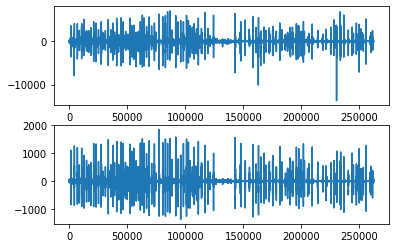

In [57]:
fig, ax = plt.subplots(2)

ax[0].plot(IMFs[0])
ax[1].plot(np.diff(IMFs[0]))

In [30]:
np.where(np.diff(np.sign(IMFs)))

(array([ 0,  0,  0, ..., 11, 12, 12]),
 array([     1,      8,     13, ..., 211170,  80422, 190755]))

In [40]:
psd

array([0.00000000e+00, 7.65082059e-04, 2.92943703e-14, ...,
       2.96496156e-05, 4.31369856e-14, 1.65155488e-04])

In [60]:
mif, mdf, smpds, amb, fmb # revisar, valores raros

(array([-1.10102188e-03,  3.38450206e-03,  1.39813037e-03,  8.06987517e-05,
         9.15789902e-05,  6.42533492e-05, -3.53997259e-05,  3.43954812e-05,
         4.64335521e-05, -7.11354120e-07,  1.92619712e-05,  1.12297738e-05,
         2.92561125e-06,  9.29268690e-06]),
 array([ 4.68450245e-06,  8.77999155e-07,  7.30622297e-07,  7.80693057e-07,
         8.73710551e-07, -1.12635040e-05, -1.70773793e-07,  2.85365602e-07,
         1.50929350e-07, -2.70863963e-07,  2.07304489e-07,  1.47952785e-08,
        -2.69502733e-07, -1.22889021e-07]),
 array([1.75337875e+09, 1.30732774e+09, 8.03102684e+08, 4.18354078e+08,
        2.68860834e+08, 1.62663434e+08, 7.95988491e+07, 3.71442163e+07,
        2.00773538e+07, 8.85075058e+06, 5.89241613e+06, 1.88354078e+06,
        8.61074388e+05, 7.16353528e+01]),
 array([ 1.34228166e+00,  7.02890084e+00,  7.30523967e+00,  2.84914964e+01,
         7.48234985e+01, -2.59495887e+00, -5.91250680e+00,  4.22498386e+02,
        -4.52335072e+01, -4.47566826e+01,  5.8

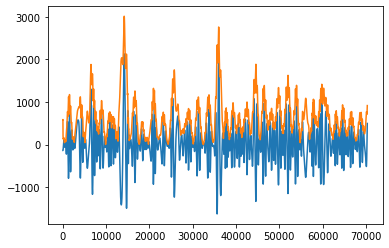

In [157]:
filt = (t > 0) * (t < 3)
plt.plot(IMFs[4][filt])
plt.plot(np.abs(phasors[4][filt]))

N2001/Myopathy/Deltoideus/N2001M03DE09
N2001/Myopathy/Deltoideus/N2001M03DE05
N2001/Myopathy/Deltoideus/N2001M03DE08
N2001/Myopathy/Deltoideus/N2001M03DE04
N2001/Myopathy/Deltoideus/N2001M07DE15
N2001/Myopathy/Deltoideus/N2001M04DE55
N2001/Myopathy/Deltoideus/N2001M03DE12
N2001/Myopathy/Deltoideus/N2001M02DE02
N2001/Myopathy/Deltoideus/N2001M07DE07
N2001/Myopathy/Deltoideus/N2001M07DE19
N2001/Myopathy/Deltoideus/N2001M02DE07
N2001/Myopathy/Deltoideus/N2001M04DE54
N2001/Myopathy/Deltoideus/N2001M02DE06
N2001/Myopathy/Deltoideus/N2001M07DE06
N2001/Myopathy/Deltoideus/N2001M04DE58
N2001/Myopathy/Deltoideus/N2001M07DE14
N2001/Myopathy/Deltoideus/N2001M04DE60
N2001/Myopathy/Deltoideus/N2001M02DE04
N2001/Myopathy/Deltoideus/N2001M07DE02
N2001/Myopathy/Deltoideus/N2001M04DE61
N2001/Myopathy/Deltoideus/N2001M04DE57
N2001/Myopathy/Deltoideus/N2001M07DE01
N2001/Myopathy/Deltoideus/N2001M07DE13
N2001/Myopathy/Deltoideus/N2001M02DE08


/tmp/ipykernel_14690/347344962.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


N2001/Myopathy/Deltoideus/N2001M03DE17
N2001/Myopathy/Deltoideus/N2001M03DE13
N2001/Myopathy/Deltoideus/N2001M03DE10
N2001/Myopathy/Deltoideus/N2001M03DE07
N2001/Myopathy/Deltoideus/N2001M07DE11
N2001/Myopathy/Deltoideus/N2001M07DE09
N2001/Myopathy/Deltoideus/N2001M03DE15


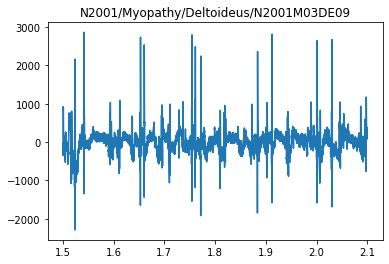

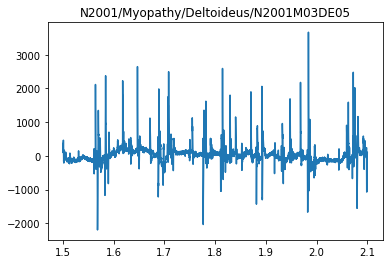

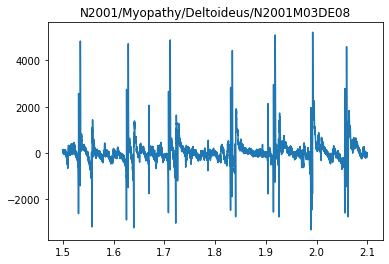

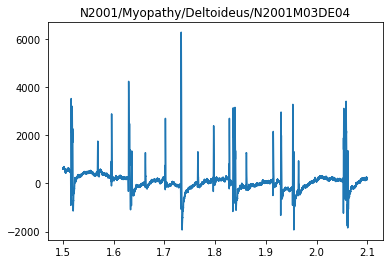

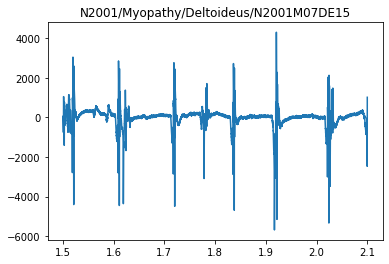

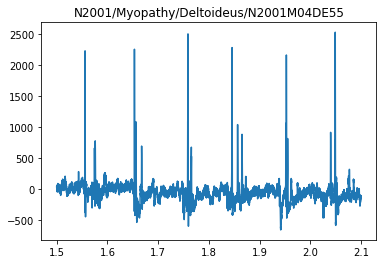

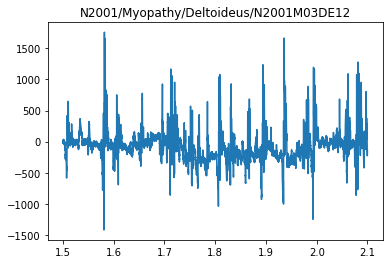

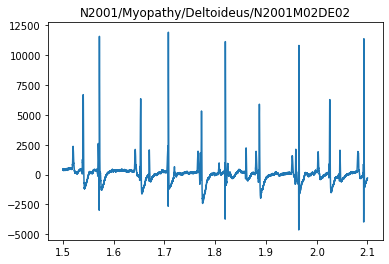

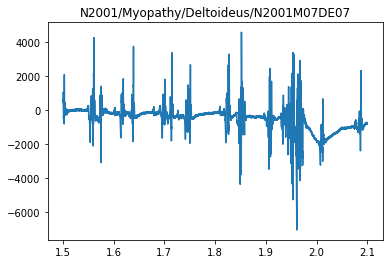

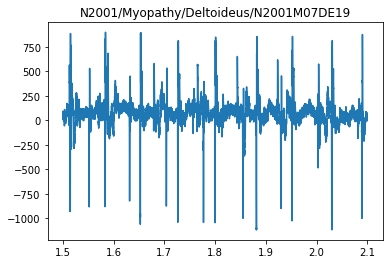

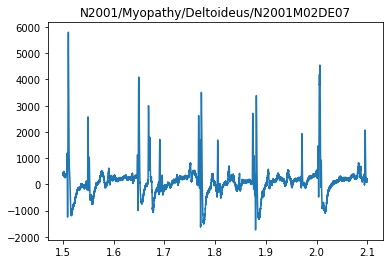

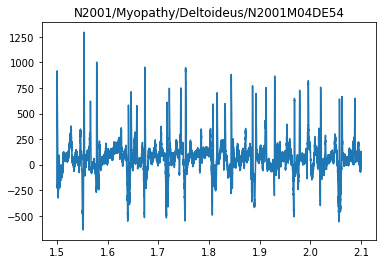

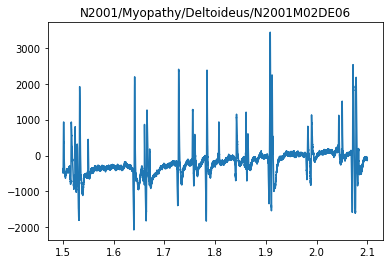

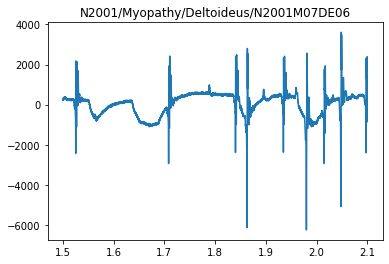

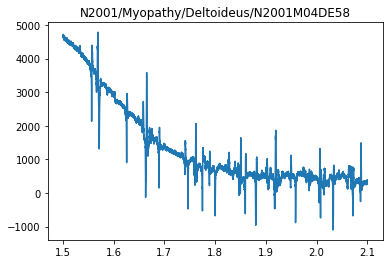

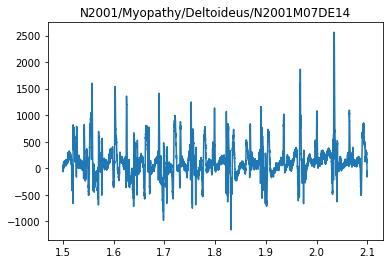

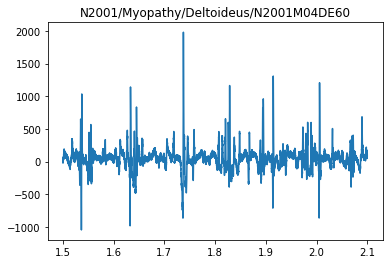

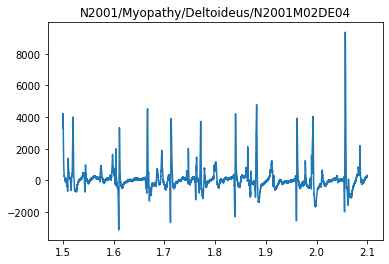

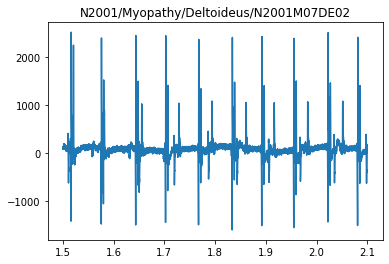

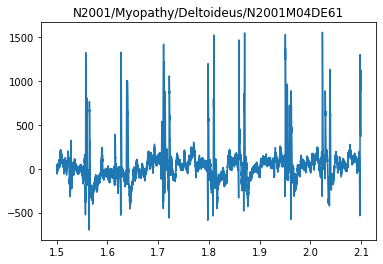

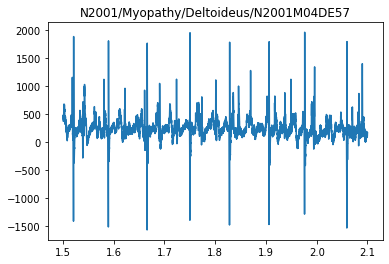

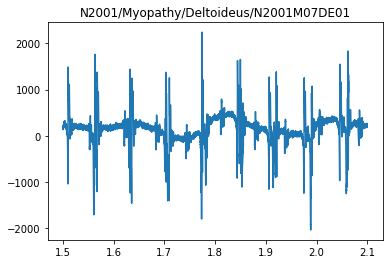

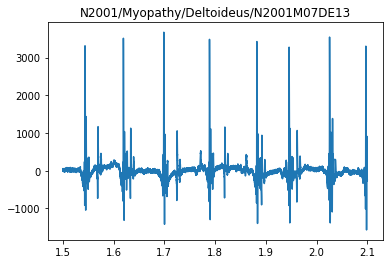

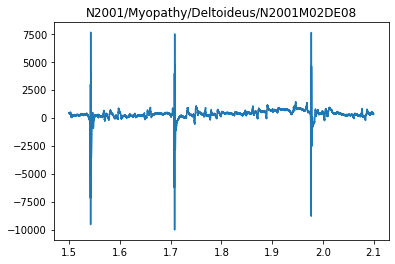

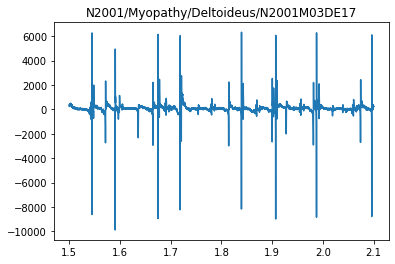

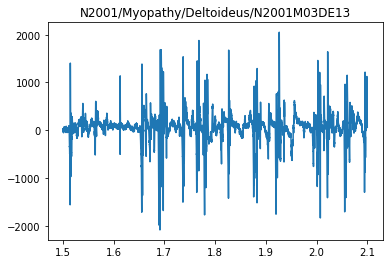

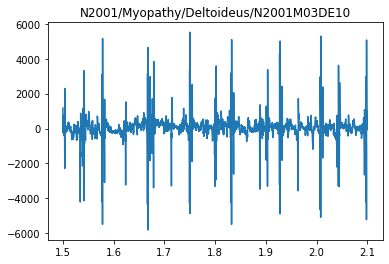

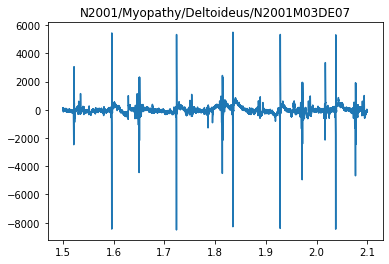

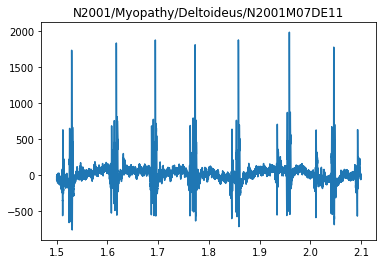

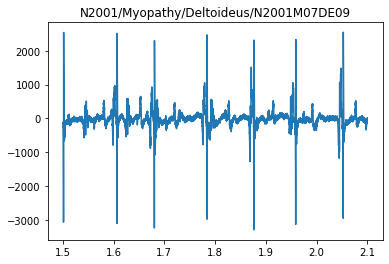

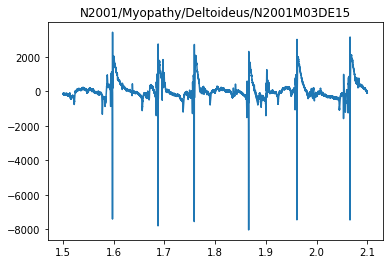

In [68]:
# import required module
import os
from scipy.io import savemat
 
# assign directory
directory = '../N2001'
 
# iterate over files in
# that directory
for c, condition in enumerate(os.scandir(directory)):
    if c == 0 or c == 1: continue
    for m, muscle in enumerate(os.scandir(condition.path)):
        if m < 4: continue
        for i, exp_dir in enumerate(os.scandir(muscle.path)):
            info = {}
            exp = exp_dir.name
            with open('{}/{}.hea'.format(exp_dir.path, exp), 'r') as f:
                line = f.readline().split(' ')
                info['n_channels'] = int(line[1])
                info['sr'] = float(line[2])
                info['sps'] = int(line[3])
                
                line = f.readline().split(' ')
                binfile = '{}/{}'.format(exp_dir.path, line[0])
                
                aux = line[1].split('+')
                info['data_format'] = int(aux[0])
                info['byte_offset'] = int(aux[1])
                
                aux = line[2].split('/')
                info['gain'] = float(aux[0])
                info['units'] = aux[1][:2]
                
                with open(binfile, 'rb') as bf:
                    data = bf.read()
                    arr = np.array(list(data), dtype=np.uint8)[info['byte_offset']:]
                    data = np.array(struct.unpack('h' * int(arr.shape[0] / 2), arr.tobytes()))
                    t = np.linspace(0, data.shape[0] / info['sr'], data.shape[0], endpoint=False)
                    
                    info['data'] = data
                    info['time'] = t
                
                savemat('{}/{}.mat'.format(exp_dir.path, exp), info)
#                 print(exp_dir.path)
#                 fig, ax = plt.subplots()
#                 filt = (t > 1.5) * (t < 2.1)
#                 ax.plot(t[filt], data[filt])
#                 ax.set_title(exp_dir.path)
                
#                 if i >= 30:
#                     break
#         break
#     break


In [29]:
import pandas as pd
df = pd.read_csv('_features.csv', index_col=0)
df

,class,subject,muscles,WL_imf1,WL_imf2,WL_imf3,WL_imf4,WL_imf5,WL_imf6,WL_imf7,...,MFD_imf4,MFD_imf5,MIF_imf1,MIF_imf2,MIF_imf3,MIF_imf4,MIF_imf6,PPSD_imf1,PPSD_imf4,PPSD_imf8
0,ALS,N2001A02VL03,VastusLateralis,719275.541718,1.094767e+06,695607.662720,321155.430702,105396.937659,34302.987162,15594.323440,...,-325.167469,-482.562139,307.007520,-6.847191e-11,-7.444091e-11,8.620300e-11,9.860339e-11,6.261909,6.271821,6.281316
1,ALS,N2001A02VL07,VastusLateralis,901196.331857,1.309321e+06,894573.313744,399395.842330,133614.067979,63540.577810,36083.492665,...,-5633.481025,-4048.327996,1547.476884,-1.839803e-09,3.911051e-10,-1.197992e-09,7.534456e-10,6.264329,6.274294,6.281319
2,ALS,N2001A02VL05,VastusLateralis,422365.577428,6.624153e+05,365766.853143,191361.453329,71083.626869,20293.106647,8085.775450,...,37.291939,-118.840633,-61.201330,-8.318322e-11,-1.548356e-10,2.571148e-12,2.012453e-11,6.256921,6.271642,6.281688


In [140]:
df_clean = df.dropna(how='any')

data_classes = pd.factorize(df_clean['class'])[0]
data_feat = np.array(df_clean[df_clean.columns[3:]])

In [143]:
from ulda import ulda, ulda_feature_reduction
ulda(data_feat, data_classes)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [71]:
columns = [f'WL_imf{i:d}' for i in range(1, 14)] + \
            [f'ZC_imf{i+1:d}' for i in zc_map] + \
            [f'SSC_imf{i+1:d}' for i in ssc_map] + \
            [f'RMS_imf{i:d}' for i in range(1, 14)] + \
            [f'AR{j+1}_imf{i+1:d}' for i in ar_map.keys() for j in ar_map[i]] + \
            [f'MAV_imf{i:d}' for i in range(1, 14)] + \
            [f'IAV_imf{i:d}' for i in range(1, 14)] + \
            [f'AMB_imf{i+1:d}' for i in amb_map] + \
            [f'FMB_imf{i+1:d}' for i in fmb_map] + \
            [f'SMPDS_imf{i+1:d}' for i in smpds_map] + \
            [f'MFD_imf{i+1:d}' for i in mfd_map] + \
            [f'MIF_imf{i+1:d}' for i in mif_map] + \
            [f'PPSD_imf{i+1:d}' for i in ppsd_map]
np.save(columns, 'col.txt')

TypeError: expected str, bytes or os.PathLike object, not list

In [30]:
features = np.empty(3)[:] = np.nan
np.save('test.npy', np.array(df.loc[0][3:], np.float32))
np.load('test.npy').shape

(103,)